#### Sort a list of elements

The purpose of the notebook is to train graph network to learn to sort a list of elements.



In [1]:
import time


from graph_nets import utils_np
from graph_nets import utils_tf
from graph_nets.demos_tf2 import models
import matplotlib.pyplot as plt
import numpy as np

import sonnet as snt
import tensorflow as tf



SEED = 1
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
# tf.argsort()

# argsort tells in what order to select elements from the array to get a sorted result
values = [1, 10, 26.9, 2.8, 166.32, 62.3]
sort_order = tf.argsort(values)
#print(sort_order)
#[0 3 1 2 5 4]
# which means take the element in position 0 (1)
# then take the one in position 3 (2.8)
# then take the one in position 1 (10)

In [75]:
def create_graph_dicts_tf(num_examples, num_elements_min_max):
  """Generate graphs for training.

  Args:
    num_examples: total number of graphs to generate
    num_elements_min_max: a 2-tuple with the minimum and maximum number of
      values allowable in a graph. The number of values for a graph is
      uniformly sampled withing this range. The upper bound is exclusive, and
      should be at least 2 more than the lower bound.

  Returns:
    inputs: contains the generated random numbers as node values.
    sort_indices: contains the sorting indices as nodes. Concretely
      inputs.nodes[sort_indices.nodes] will be a sorted array.
    ranks: the rank of each value in inputs normalized to the range [0, 1].
  """
  num_elements = tf.random.uniform(
      [num_examples],
      minval=num_elements_min_max[0],
      maxval=num_elements_min_max[1],
      dtype=tf.int32)
  inputs_graphs = []
  sort_indices_graphs = []
  ranks_graphs = []
  for i in range(num_examples):
    values = tf.random.uniform(shape=[num_elements[i]])#generate random features for each node of the graph
    sort_indices = tf.cast(
        tf.argsort(values, axis=-1), tf.float32)
    ranks = tf.cast(
        tf.argsort(sort_indices, axis=-1), tf.float32) / (
            tf.cast(num_elements[i], tf.float32) - 1.0)
    inputs_graphs.append({"nodes": values[:, None]})
    sort_indices_graphs.append({"nodes": sort_indices[:, None]})
    ranks_graphs.append({"nodes": ranks[:, None]})
  return inputs_graphs, sort_indices_graphs, ranks_graphs

In [76]:
graphs, indices, ranks =create_graph_dicts_tf(3,(3,8))
print(f'The number of graphs creates is : {len(graphs)}')
print(f'type {type(graphs)}')
print(f'type element {type(graphs[0])}')
print(f'the first graph is {graphs[0]["nodes"]}')
print(f'the sorted indices are {indices[0]["nodes"]}')

The number of graphs creates is : 3
type <class 'list'>
type element <class 'dict'>
the first graph is [[0.95214367]
 [0.7892797 ]
 [0.3518337 ]
 [0.04095459]
 [0.61420333]
 [0.8480252 ]]
the sorted indices are [[3.]
 [2.]
 [4.]
 [1.]
 [5.]
 [0.]]


In [80]:
def create_linked_list_target(batch_size, input_graphs):
  """Creates linked list targets.

  Returns a graph with the same number of nodes as `input_graph`. Each node
  contains a 2d vector with targets for a 1-class classification where only one
  node is `True`, the smallest value in the array. The vector contains two
  values: [prob_true, prob_false].
  It also contains edges connecting all nodes. These are again 2d vectors with
  softmax targets [prob_true, prob_false]. An edge is True
  if n+1 is the element immediately after n in the sorted list.

  Args:
    batch_size: batch size for the `input_graphs`.
    input_graphs: a `graphs.GraphsTuple` which contains a batch of inputs.

  Returns:
    A `graphs.GraphsTuple` with the targets, which encode the linked list.
  """
  target_graphs = []
  for i in range(batch_size):
    input_graph = utils_tf.get_graph(input_graphs, i)
    num_elements = tf.shape(input_graph.nodes)[0]
    si = tf.cast(tf.squeeze(input_graph.nodes), tf.int32)
    nodes = tf.reshape(tf.one_hot(si[:1], num_elements), (-1, 1))
    x = tf.stack((si[:-1], si[1:]))[None]
    y = tf.stack(
        (input_graph.senders, input_graph.receivers), axis=1)[:, :, None]
    edges = tf.reshape(
        tf.cast(
            tf.reduce_any(tf.reduce_all(tf.equal(x, y), axis=1), axis=1),
            tf.float32), (-1, 1))
    target_graphs.append(input_graph._replace(nodes=nodes, edges=edges))
  return utils_tf.concat(target_graphs, axis=0)

In [106]:
## graphs having only nodes
inputs, sort_indices, ranks = create_graph_dicts_tf(
      1, (3,8)) 

## transform disctionary in graphs tuple
inputs = utils_tf.data_dicts_to_graphs_tuple(inputs)
sort_indices = utils_tf.data_dicts_to_graphs_tuple(sort_indices)

## add edges for create a fully connected graph
inputs = utils_tf.fully_connect_graph_dynamic(inputs)
sort_indices = utils_tf.fully_connect_graph_dynamic(sort_indices)

targets = create_linked_list_target(1, sort_indices)

In [109]:
sort_indices
## edge that will be put to 1 are:
## edge 2->1
## edge 1->3
## edge 3->0

GraphsTuple(nodes=<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
array([[2.],
       [1.],
       [3.],
       [0.]], dtype=float32)>, edges=None, receivers=<tf.Tensor: shape=(16,), dtype=int32, numpy=array([0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3])>, senders=<tf.Tensor: shape=(16,), dtype=int32, numpy=array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3])>, globals=None, n_node=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([4])>, n_edge=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([16])>)

In [107]:
inputs.nodes

<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
array([[0.7760526 ],
       [0.47332907],
       [0.21168268],
       [0.7466848 ]], dtype=float32)>

In [108]:
targets
## the node setted to 1 is the smallest one
## the edges setted to 1 are 
## edge 2->1
## edge 1->3
## edge 3->0

GraphsTuple(nodes=<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [1.],
       [0.]], dtype=float32)>, edges=<tf.Tensor: shape=(16, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.]], dtype=float32)>, receivers=<tf.Tensor: shape=(16,), dtype=int32, numpy=array([0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3])>, senders=<tf.Tensor: shape=(16,), dtype=int32, numpy=array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3])>, globals=None, n_node=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([4])>, n_edge=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([16])>)

In [111]:
## each node and each edge becomes a 2d vector [prob_true, prob_false]
nodes = tf.concat((targets.nodes, 1.0 - targets.nodes), axis=1)
edges = tf.concat((targets.edges, 1.0 - targets.edges), axis=1)

In [112]:
nodes

<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)>

In [113]:
edges

<tf.Tensor: shape=(16, 2), dtype=float32, numpy=
array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)>

In [114]:
def create_data(batch_size, num_elements_min_max):
  """Returns graphs containing the inputs and targets for classification.

  Refer to create_data_dicts_tf and create_linked_list_target for more details.

  Args:
    batch_size: batch size for the `input_graphs`.
    num_elements_min_max: a 2-`tuple` of `int`s which define the [lower, upper)
      range of the number of elements per list.

  Returns:
    inputs: a `graphs.GraphsTuple` which contains the input list as a graph.
    targets: a `graphs.GraphsTuple` which contains the target as a graph.
    sort_indices: a `graphs.GraphsTuple` which contains the sort indices of
      the list elements a graph.
    ranks: a `graphs.GraphsTuple` which contains the ranks of the list
      elements as a graph.
  """
  inputs, sort_indices, ranks = create_graph_dicts_tf(
      batch_size, num_elements_min_max)
  inputs = utils_tf.data_dicts_to_graphs_tuple(inputs)
  sort_indices = utils_tf.data_dicts_to_graphs_tuple(sort_indices)
  ranks = utils_tf.data_dicts_to_graphs_tuple(ranks)

  inputs = utils_tf.fully_connect_graph_dynamic(inputs)
  sort_indices = utils_tf.fully_connect_graph_dynamic(sort_indices)
  ranks = utils_tf.fully_connect_graph_dynamic(ranks)

  targets = create_linked_list_target(batch_size, sort_indices)
  nodes = tf.concat((targets.nodes, 1.0 - targets.nodes), axis=1)
  edges = tf.concat((targets.edges, 1.0 - targets.edges), axis=1)
  targets = targets._replace(nodes=nodes, edges=edges)

  return inputs, targets, sort_indices, ranks

In [141]:
def plot_linked_list(ax, graph, sort_indices):
  """Plot a networkx graph containing weights for the linked list probability."""
  nd = len(graph.nodes())
  probs = np.zeros((nd, nd))
  for edge in graph.edges(data=True):

    # edge[0] sender
    # edge[1] receiver
    # edge[2]['features'][0] probability of the edge to be true 

    probs[edge[0], edge[1]] = edge[2]["features"][0]
    
  ax.matshow(probs[sort_indices][:, sort_indices], cmap="viridis")
  ax.grid(False)

In [134]:
utils_np.graphs_tuple_to_networkxs(targets)[0].edges()

OutMultiEdgeDataView([(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6)])

In [140]:
utils_np.graphs_tuple_to_networkxs(targets)[0].edges(data=True)

OutMultiEdgeDataView([(0, 0, OrderedDict([('index', 0), ('features', array([0., 1.], dtype=float32))])), (0, 1, OrderedDict([('index', 1), ('features', array([0., 1.], dtype=float32))])), (0, 2, OrderedDict([('index', 2), ('features', array([0., 1.], dtype=float32))])), (0, 3, OrderedDict([('index', 3), ('features', array([0., 1.], dtype=float32))])), (0, 4, OrderedDict([('index', 4), ('features', array([1., 0.], dtype=float32))])), (0, 5, OrderedDict([('index', 5), ('features', array([0., 1.], dtype=float32))])), (0, 6, OrderedDict([('index', 6), ('features', array([0., 1.], dtype=float32))])), (1, 0, OrderedDict([('index', 7), ('features', array([0., 1.], dtype=float32))])), (1, 1, OrderedDict([('index', 8), ('features', array([0., 1.], dtype=float32))])), (1, 2, OrderedDict([('index', 9), ('features', array([0., 1.], dtype=float32))])), (1, 3, OrderedDict([('index', 10), ('features', array([0., 1.], dtype=float32))])), (1, 4, OrderedDict([('index', 11), ('features', array([0., 1.], 

[[0.14408815]
 [0.6758317 ]
 [0.9958906 ]
 [0.24030685]
 [0.47656298]
 [0.8461859 ]]
[0 3 4 1 5 2]


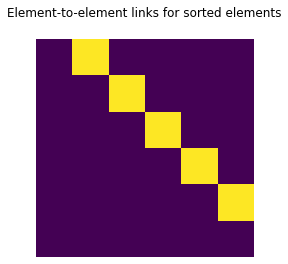

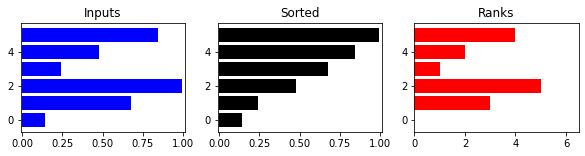

In [142]:
num_elements_min_max = (5, 10)

inputs, targets, sort_indices, ranks = create_data(
    1, num_elements_min_max)

inputs_nodes = inputs.nodes.numpy()
targets = utils_tf.nest_to_numpy(targets)
sort_indices_nodes = sort_indices.nodes.numpy()
ranks_nodes = ranks.nodes.numpy()

sort_indices = np.squeeze(sort_indices_nodes).astype(int)## squeeze the 2d array in 1d array
print(inputs_nodes)
print(sort_indices)

# Plot sort linked lists.
# The matrix plots show each element from the sorted list (rows), and which
# element they link to as next largest (columns). Ground truth is a diagonal
# offset toward the upper-right by one.

fig = plt.figure(1, figsize=(4, 4))
fig.clf()
ax = fig.add_subplot(1, 1, 1)
plot_linked_list(ax,
                 utils_np.graphs_tuple_to_networkxs(targets)[0], sort_indices)
ax.set_title("Element-to-element links for sorted elements")
ax.set_axis_off()

fig = plt.figure(2, figsize=(10, 2))
fig.clf()
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

i = 0
num_elements = ranks_nodes.shape[0]
inputs = np.squeeze(inputs_nodes)
ranks = np.squeeze(ranks_nodes * (num_elements - 1.0)).astype(int)
x = np.arange(inputs.shape[0])

ax1.set_title("Inputs")
ax1.barh(x, inputs, color="b")
ax1.set_xlim(-0.01, 1.01)

ax2.set_title("Sorted")
ax2.barh(x, inputs[sort_indices], color="k")
ax2.set_xlim(-0.01, 1.01)

ax3.set_title("Ranks")
ax3.barh(x, ranks, color="r")
_ = ax3.set_xlim(0, len(ranks) + 0.5)

In [ ]:
# The model we explore includes three components:
# - An "Encoder" graph net, which independently encodes the edge, node, and
#   global attributes (does not compute relations etc.).
# - A "Core" graph net, which performs N rounds of processing (message-passing)
#   steps. The input to the Core is the concatenation of the Encoder's output
#   and the previous output of the Core (labeled "Hidden(t)" below, where "t" is
#   the processing step).
# - A "Decoder" graph net, which independently decodes the edge, node, and
#   global attributes (does not compute relations etc.), on each
#   message-passing step.
#
#                     Hidden(t)   Hidden(t+1)
#                        |            ^
#           *---------*  |  *------*  |  *---------*
#           |         |  |  |      |  |  |         |
# Input --->| Encoder |  *->| Core |--*->| Decoder |---> Output(t)
#           |         |---->|      |     |         |
#           *---------*     *------*     *---------*
#
# The model is trained by supervised learning. Input graphs are procedurally
# generated, and output graphs have the same structure with the nodes and edges
# of the linked list labeled (using 2-element 1-hot vectors). The target
# labels the node corresponding to the lowest value in the list, and labels each
# which represents the connection between neighboring values in the sorted
# list.
#
# The training loss is computed on the output of each processing step. The
# reason for this is to encourage the model to try to solve the problem in as
# few steps as possible. It also helps make the output of intermediate steps
# more interpretable.
#
# There's no need for a separate evaluate dataset because the inputs are
# never repeated, so the training loss is the measure of performance on graphs
# from the input distribution.
#
# We also evaluate how well the models generalize to lists which are up to
# twice as large as those on which it was trained. The loss is computed only
# on the final processing step.
#
# Variables with the suffix _tr are training parameters, and variables with the
# suffix _ge are test/generalization parameters.
#
# After around 2000-5000 training iterations the model reaches near-perfect
# performance on lists with between 8-16 elements.

In [147]:
def compute_accuracy(target, output):
  """Calculate model accuracy.

  Returns the number of correctly predicted links and the number
  of completely solved list sorts (100% correct predictions).

  Args:
    target: A `graphs.GraphsTuple` that contains the target graph.
    output: A `graphs.GraphsTuple` that contains the output graph.

  Returns:
    correct: A `float` fraction of correctly labeled nodes/edges.
    solved: A `float` fraction of graphs that are completely correctly labeled.
  """
  tdds = utils_np.graphs_tuple_to_data_dicts(target)
  odds = utils_np.graphs_tuple_to_data_dicts(output)
  cs = []
  ss = []
  for td, od in zip(tdds, odds):
    num_elements = td["nodes"].shape[0]
    xn = np.argmax(td["nodes"], axis=-1)
    yn = np.argmax(od["nodes"], axis=-1)

    xe = np.reshape(
        np.argmax(
            np.reshape(td["edges"], (num_elements, num_elements, 2)), axis=-1),
        (-1,))
    ye = np.reshape(
        np.argmax(
            np.reshape(od["edges"], (num_elements, num_elements, 2)), axis=-1),
        (-1,))
    c = np.concatenate((xn == yn, xe == ye), axis=0)
    s = np.all(c)
    cs.append(c)
    ss.append(s)
  correct = np.mean(np.concatenate(cs, axis=0))
  solved = np.mean(np.stack(ss))
  return correct, solved

def create_loss(target, outputs):
  """

  Args:
    target: a `graphs.GraphsTuple` which contains the target as a graph.
    outputs: a `list` of `graphs.GraphsTuple`s which contains the model
      outputs for each processing step as graphs.

  Returns:
    A `list` of ops which are the loss for each processing step.

  """
  
  # if not isinstance(outputs, collections.Sequence):
  #   outputs = [outputs]

  losss = [
      tf.compat.v1.losses.softmax_cross_entropy(target.nodes, output.nodes) +
      tf.compat.v1.losses.softmax_cross_entropy(target.edges, output.edges)
      for output in outputs
  ]
  return tf.stack(losss)

In [148]:
# Training.
def update_step(inputs_tr, targets_tr):
  with tf.GradientTape() as tape:
    outputs_tr = model(inputs_tr, num_processing_steps_tr)
    # Loss.
    loss_tr = create_loss(targets_tr, outputs_tr)
    loss_tr = tf.math.reduce_sum(loss_tr) / num_processing_steps_tr

  gradients = tape.gradient(loss_tr, model.trainable_variables)
  optimizer.apply(gradients, model.trainable_variables)
  return outputs_tr, loss_tr

In [146]:
# Data.
@tf.function
def get_data():

  inputs_tr, targets_tr, sort_indices_tr, _ = create_data(
      batch_size_tr, num_elements_min_max_tr)

  inputs_tr = utils_tf.set_zero_edge_features(inputs_tr, 1)
  inputs_tr = utils_tf.set_zero_global_features(inputs_tr, 1)
  
  # Test/generalization.
  inputs_ge, targets_ge, sort_indices_ge, _ = create_data(
      batch_size_ge, num_elements_min_max_ge)
  inputs_ge = utils_tf.set_zero_edge_features(inputs_ge, 1)
  inputs_ge = utils_tf.set_zero_global_features(inputs_ge, 1)

  targets_tr = utils_tf.set_zero_global_features(targets_tr, 1)
  targets_ge = utils_tf.set_zero_global_features(targets_ge, 1)

  return inputs_tr, targets_tr, sort_indices_tr, inputs_ge, targets_ge, sort_indices_ge

In [149]:
# Model parameters.
# Number of processing (message-passing) steps.
num_processing_steps_tr = 10
num_processing_steps_ge = 10

# Data / training parameters.
num_training_iterations = 3000
batch_size_tr = 32
batch_size_ge = 100
# Number of elements in each list is sampled uniformly from this range.
num_elements_min_max_tr = (8, 17)
num_elements_min_max_ge = (16, 33)


# Optimizer.
learning_rate = 1e-3
optimizer = snt.optimizers.Adam(learning_rate)

model = models.EncodeProcessDecode(edge_output_size=2, node_output_size=2)
last_iteration = 0
logged_iterations = []
losses_tr = []
corrects_tr = []
solveds_tr = []
losses_ge = []
corrects_ge = []
solveds_ge = []

In [160]:
# Get some example data that resembles the tensors that will be fed
# into update_step():
example_input_data, example_target_data = get_data()[:2]

# Get the input signature for that function by obtaining the specs
input_signature = [
  utils_tf.specs_from_graphs_tuple(example_input_data),
  utils_tf.specs_from_graphs_tuple(example_target_data)
]

# Compile the update function using the input signature for speedy code.
compiled_update_step = tf.function(update_step, input_signature=input_signature)
#compiled_update_step_2 = update_step(example_input_data,example_target_data)

In [169]:
compiled_update_step

#### Training

In [170]:
# How much time between logging and printing the current results.
log_every_seconds = 20

print("# (iteration number), T (elapsed seconds), "
      "Ltr (training loss), Lge (test/generalization loss), "
      "Ctr (training fraction nodes/edges labeled correctly), "
      "Str (training fraction examples solved correctly), "
      "Cge (test/generalization fraction nodes/edges labeled correctly), "
      "Sge (test/generalization fraction examples solved correctly)")

start_time = time.time()
last_log_time = start_time
for iteration in range(last_iteration, num_training_iterations):
  last_iteration = iteration
  (inputs_tr, targets_tr, sort_indices_tr,
   inputs_ge, targets_ge, sort_indices_ge) = get_data()

  outputs_tr, loss_tr = compiled_update_step(inputs_tr, targets_tr)

  the_time = time.time()
  elapsed_since_last_log = the_time - last_log_time
  if elapsed_since_last_log > log_every_seconds:
    last_log_time = the_time
    outputs_ge = model(inputs_ge, num_processing_steps_ge)
    losss_ge = create_loss(targets_ge, outputs_ge)
    loss_ge = losss_ge[-1]

    # Replace the globals again to prevent exceptions.
    outputs_tr[-1] = outputs_tr[-1].replace(globals=None)
    targets_tr = targets_tr.replace(globals=None)

    correct_tr, solved_tr = compute_accuracy(
        utils_tf.nest_to_numpy(targets_tr),
        utils_tf.nest_to_numpy(outputs_tr[-1]))
    correct_ge, solved_ge = compute_accuracy(
        utils_tf.nest_to_numpy(targets_ge),
        utils_tf.nest_to_numpy(outputs_ge[-1]))
    elapsed = time.time() - start_time
    losses_tr.append(loss_tr.numpy())
    corrects_tr.append(correct_tr)
    solveds_tr.append(solved_tr)
    losses_ge.append(loss_ge.numpy())
    corrects_ge.append(correct_ge)
    solveds_ge.append(solved_ge)
    logged_iterations.append(iteration)
    print("# {:05d}, T {:.1f}, Ltr {:.4f}, Lge {:.4f}, Ctr {:.4f}, "
          "Str {:.4f}, Cge {:.4f}, Sge {:.4f}".format(
              iteration, elapsed, loss_tr.numpy(), loss_ge.numpy(),
              correct_tr, solved_tr, correct_ge, solved_ge))

# (iteration number), T (elapsed seconds), Ltr (training loss), Lge (test/generalization loss), Ctr (training fraction nodes/edges labeled correctly), Str (training fraction examples solved correctly), Cge (test/generalization fraction nodes/edges labeled correctly), Sge (test/generalization fraction examples solved correctly)


c:\Users\calni\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\framework\indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/EncodeProcessDecode/MLPGraphNetwork/graph_network/edge_block/broadcast_receiver_nodes_to_edges_5/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/EncodeProcessDecode/MLPGraphNetwork/graph_network/edge_block/broadcast_receiver_nodes_to_edges_5/Reshape:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradient_tape/EncodeProcessDecode/MLPGraphNetwork/graph_network/edge_block/broadcast_receiver_nodes_to_edges_5/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
c:\Users\calni\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\framework\indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/E

# 00162, T 20.6, Ltr 0.3202, Lge 0.2304, Ctr 0.9311, Str 0.0000, Cge 0.9623, Sge 0.0000
# 00477, T 40.7, Ltr 0.1687, Lge 0.1424, Ctr 0.9460, Str 0.0000, Cge 0.9565, Sge 0.0000
# 00792, T 60.7, Ltr 0.2977, Lge 0.2180, Ctr 0.9326, Str 0.0000, Cge 0.9630, Sge 0.0000
# 01105, T 80.7, Ltr 0.0314, Lge 0.1523, Ctr 0.9998, Str 0.9688, Cge 0.9752, Sge 0.0900
# 01418, T 100.7, Ltr 0.0306, Lge 0.1093, Ctr 0.9996, Str 0.9375, Cge 0.9878, Sge 0.3600
# 01731, T 120.7, Ltr 0.0289, Lge 0.0526, Ctr 1.0000, Str 1.0000, Cge 0.9865, Sge 0.2600
# 02035, T 140.8, Ltr 0.0227, Lge 0.0755, Ctr 1.0000, Str 1.0000, Cge 0.9820, Sge 0.2100
# 02334, T 160.8, Ltr 0.0159, Lge 0.0526, Ctr 1.0000, Str 1.0000, Cge 0.9880, Sge 0.3000
# 02625, T 181.0, Ltr 0.0239, Lge 0.0455, Ctr 1.0000, Str 1.0000, Cge 0.9854, Sge 0.3800
# 02912, T 200.8, Ltr 0.0151, Lge 0.0392, Ctr 1.0000, Str 1.0000, Cge 0.9887, Sge 0.2200


#### Plots

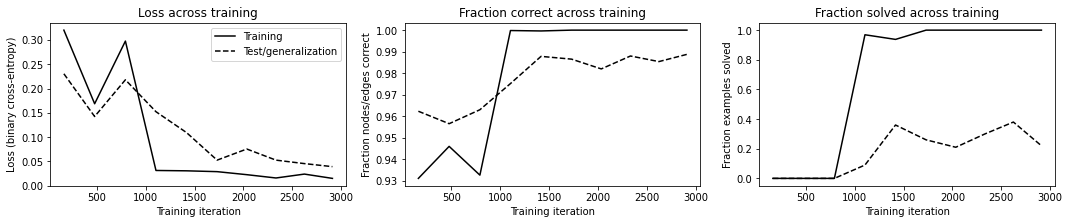

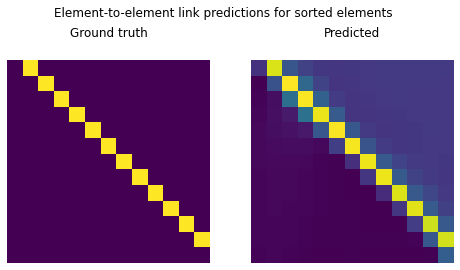

In [171]:
# Plot results curves.
fig = plt.figure(11, figsize=(18, 3))
fig.clf()
x = np.array(logged_iterations)
# Loss.
y_tr = losses_tr
y_ge = losses_ge
ax = fig.add_subplot(1, 3, 1)
ax.plot(x, y_tr, "k", label="Training")
ax.plot(x, y_ge, "k--", label="Test/generalization")
ax.set_title("Loss across training")
ax.set_xlabel("Training iteration")
ax.set_ylabel("Loss (binary cross-entropy)")
ax.legend()
# Correct.
y_tr = corrects_tr
y_ge = corrects_ge
ax = fig.add_subplot(1, 3, 2)
ax.plot(x, y_tr, "k", label="Training")
ax.plot(x, y_ge, "k--", label="Test/generalization")
ax.set_title("Fraction correct across training")
ax.set_xlabel("Training iteration")
ax.set_ylabel("Fraction nodes/edges correct")
# Solved.
y_tr = solveds_tr
y_ge = solveds_ge
ax = fig.add_subplot(1, 3, 3)
ax.plot(x, y_tr, "k", label="Training")
ax.plot(x, y_ge, "k--", label="Test/generalization")
ax.set_title("Fraction solved across training")
ax.set_xlabel("Training iteration")
ax.set_ylabel("Fraction examples solved")

# Plot sort linked lists for test/generalization.
# The matrix plots show each element from the sorted list (rows), and which
# element they link to as next largest (columns). Ground truth is a diagonal
# offset toward the upper-right by one.
outputs = utils_np.graphs_tuple_to_networkxs(outputs_tr[-1])
targets = utils_np.graphs_tuple_to_networkxs(targets_tr)
inputs = utils_np.graphs_tuple_to_networkxs(inputs_tr)
batch_element = 0
fig = plt.figure(12, figsize=(8, 4.5))
fig.clf()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
sort_indices = np.squeeze(
    utils_np.get_graph(sort_indices_tr,
                       batch_element).nodes).astype(int)
fig.suptitle("Element-to-element link predictions for sorted elements")
plot_linked_list(ax1, targets[batch_element], sort_indices)
ax1.set_title("Ground truth")
ax1.set_axis_off()
plot_linked_list(ax2, outputs[batch_element], sort_indices)
ax2.set_title("Predicted")
ax2.set_axis_off()